In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Read Datasets / Finding Information about Datasets

In [92]:
data = pd.read_csv('/Users/anshita/Downloads/Uptrail/Week 3/streamworks_user_data.csv')

In [93]:
data.head()

,user_id,age,gender,signup_date,last_active_date,country,subscription_type,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee
0,1001.0,56.0,Other,02-04-25,13-07-25,France,Standard,42.6,77.4,1.0,No,No,1.0,10.99
1,1002.0,69.0,Male,02-01-23,13-07-25,India,Basic,65.3,98.0,4.0,No,Yes,1.0,5.99
2,1003.0,46.0,Male,21-08-22,13-07-25,UK,Premium,40.1,47.8,0.0,No,Yes,1.0,13.99
3,1004.0,32.0,Other,14-09-23,13-07-25,Germany,Premium,5.8,53.2,1.0,Yes,Yes,1.0,13.99
4,1005.0,60.0,Female,29-07-23,13-07-25,India,Standard,32.7,16.8,5.0,No,Yes,0.0,9.99


In [94]:
print("Shape:",data.shape)

Shape: (1500, 14)


In [95]:
print("\n Column names:")
print(data.columns.tolist())


 Column names:
['user_id', 'age', 'gender', 'signup_date', 'last_active_date', 'country', 'subscription_type', 'average_watch_hours', 'mobile_app_usage_pct', 'complaints_raised', 'received_promotions', 'referred_by_friend', 'is_churned', 'monthly_fee']


# Check Missing Value

In [96]:
data.isnull().sum()

user_id                   2
age                       3
gender                    1
signup_date               2
last_active_date          2
country                   3
subscription_type         3
average_watch_hours       4
mobile_app_usage_pct      2
complaints_raised         3
received_promotions       3
referred_by_friend        3
is_churned                1
monthly_fee             145
dtype: int64

In [97]:
missing_counts = data.isna().sum()
missing_percent = (missing_counts / len(data) * 100).round(2)
data_quality_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    '% Missing': missing_percent
})
print("\nData Quality Summary:\n", data_quality_summary)


Data Quality Summary:
                       Missing Values  % Missing
user_id                            2       0.13
age                                3       0.20
gender                             1       0.07
signup_date                        2       0.13
last_active_date                   2       0.13
country                            3       0.20
subscription_type                  3       0.20
average_watch_hours                4       0.27
mobile_app_usage_pct               2       0.13
complaints_raised                  3       0.20
received_promotions                3       0.20
referred_by_friend                 3       0.20
is_churned                         1       0.07
monthly_fee                      145       9.67


# Data cleaning and Feature Engineering 

In [98]:
# Standardize column names (lowercase + strip spaces)
data.columns = data.columns.str.strip().str.lower()

In [99]:
# Fill missing subscription_type first
data["subscription_type"] = data["subscription_type"].fillna(data["subscription_type"].mode()[0])

# Group-wise fill for monthly_fee
data["monthly_fee"] = data.groupby("subscription_type")["monthly_fee"].apply(
    lambda grp: grp.fillna(grp.median())
).reset_index(level=0, drop=True)

In [100]:
####------------------------------------Data Cleaning-----------------------------------------------------####
# Drop rows where target is_churned is missing
data = data.dropna(subset=["is_churned"])

# Convert dates to datetime
data["signup_date"] = pd.to_datetime(data["signup_date"], dayfirst=True, errors="coerce")
data["last_active_date"] = pd.to_datetime(data["last_active_date"], dayfirst=True, errors="coerce")

# Drop rows where dates are missing or invalid
data = data.dropna(subset=["signup_date", "last_active_date"])

# Fill missing numerical values
num_cols = ["age", "average_watch_hours", "mobile_app_usage_pct", "complaints_raised"]
for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

# Fill monthly_fee by subscription_type median
data["monthly_fee"] = data.groupby("subscription_type")["monthly_fee"].transform(
    lambda x: x.fillna(x.median())
)

# Fill missing categorical values with mode
cat_cols = ["gender", "country", "subscription_type", "received_promotions", "referred_by_friend"]
for col in cat_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Drop user_id (not predictive)
data = data.drop(columns=["user_id"])

print("After cleaning, shape:", data.shape)
print(data.isnull().sum())

After cleaning, shape: (1495, 13)
age                     0
gender                  0
signup_date             0
last_active_date        0
country                 0
subscription_type       0
average_watch_hours     0
mobile_app_usage_pct    0
complaints_raised       0
received_promotions     0
referred_by_friend      0
is_churned              0
monthly_fee             0
dtype: int64


In [101]:
# ================== Feature Engineering ==================

# Creating new features Tenure in days
data["tenure_days"] = (data["last_active_date"] - data["signup_date"]).dt.days

# Loyalty flag
data["is_loyal"] = (data["tenure_days"] > 180).astype(int)

# Watch per fee ratio
data["watch_per_fee_ratio"] = data["average_watch_hours"] / data["monthly_fee"]

# Heavy mobile user flag
data["heavy_mobile_user"] = (data["mobile_app_usage_pct"] > 70).astype(int)

# Example interaction feature: low watch time + received promotions
data["promo_low_watch"] = ((data["average_watch_hours"] < data["average_watch_hours"].median()) &
                           (data["received_promotions"] == 1)).astype(int)

# Age binning
bins = [0, 18, 25, 35, 50, 100]
labels = ["<18", "18-25", "26-35", "36-50", "50+"]
data["age_group"] = pd.cut(data["age"], bins=bins, labels=labels, right=False)

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=["gender", "country", "subscription_type", "age_group"],
                      drop_first=True)

In [102]:
print("Final dataset shape after feature engineering:", data.shape)
data.head()

Final dataset shape after feature engineering: (1495, 28)


,age,signup_date,last_active_date,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee,...,country_Germany,country_India,country_UK,country_USA,subscription_type_Premium,subscription_type_Standard,age_group_18-25,age_group_26-35,age_group_36-50,age_group_50+
0,56.0,2025-04-02,2025-07-13,42.6,77.4,1.0,No,No,1.0,10.99,...,0,0,0,0,0,1,0,0,0,1
1,69.0,2023-01-02,2025-07-13,65.3,98.0,4.0,No,Yes,1.0,5.99,...,0,1,0,0,0,0,0,0,0,1
2,46.0,2022-08-21,2025-07-13,40.1,47.8,0.0,No,Yes,1.0,13.99,...,0,0,1,0,1,0,0,0,1,0
3,32.0,2023-09-14,2025-07-13,5.8,53.2,1.0,Yes,Yes,1.0,13.99,...,1,0,0,0,1,0,0,1,0,0
4,60.0,2023-07-29,2025-07-13,32.7,16.8,5.0,No,Yes,0.0,9.99,...,0,1,0,0,0,1,0,0,0,1


# Statistical Analysis 

In [103]:
# Ensure target is numeric int
data["is_churned"] = data["is_churned"].astype(int)

# ---------- Helpers to robustly access binary versions of variables ----------
def get_binary_series(df, base_name):
    """
    Returns a numeric 0/1 Series for a categorical Yes/No column.
    Works if the original column exists (Yes/No), or if a dummy like '<col>_Yes' exists,
    or if the column is already numeric.
    """
    if base_name in df.columns:
        s = df[base_name]
        if s.dtype == "O":
            return s.astype(str).str.strip().str.lower().map({"yes":1,"no":0,"1":1,"0":0,"true":1,"false":0}).fillna(0).astype(int)
        if np.issubdtype(s.dtype, np.number):
            return s.fillna(0).astype(int)
    for c in [f"{base_name}_Yes", f"{base_name}_yes"]:
        if c in df.columns:
            return df[c].fillna(0).astype(int)
    return None

prom_bin = get_binary_series(data, "received_promotions")
ref_bin  = get_binary_series(data, "referred_by_friend")



In [104]:
# Gender for chi-square: prefer original if available, else fallback to dummy "gender_Male"
if "gender" in data.columns:
    gender_for_test = data["gender"].astype(str).str.strip()
else:
    # build Male/Not Male from dummy if available
    gcol = "gender_Male" if "gender_Male" in data.columns else ("gender_male" if "gender_male" in data.columns else None)
    gender_for_test = pd.Series(np.where(data[gcol]==1, "Male", "Not Male"), index=data.index) if gcol else None

def chi_square_test(cat_series, target, title):
    ct = pd.crosstab(cat_series, target)
    chi2, p, dof, _ = chi2_contingency(ct)
    print(f"{title}\nContingency table:\n{ct}\nchi2={chi2:.3f}, dof={dof}, p-value={p:.6f}\n")


In [105]:
from scipy.stats import chi2_contingency, ttest_ind

# --- Chi-square tests: churn vs gender / promotions / referral ---
if gender_for_test is not None:
    chi_square_test(gender_for_test, data["is_churned"], "Chi-square: Churn ~ Gender")
if prom_bin is not None:
    chi_square_test(prom_bin, data["is_churned"], "Chi-square: Churn ~ Received Promotions (0=No,1=Yes)")
if ref_bin is not None:
    chi_square_test(ref_bin, data["is_churned"], "Chi-square: Churn ~ Referred by Friend (0=No,1=Yes)")


Chi-square: Churn ~ Gender
Contingency table:
is_churned    0    1
row_0               
Male        377  105
Not Male    769  244
chi2=0.843, dof=1, p-value=0.358455

Chi-square: Churn ~ Received Promotions (0=No,1=Yes)
Contingency table:
is_churned             0    1
received_promotions          
0                    572  192
1                    574  157
chi2=2.586, dof=1, p-value=0.107811

Chi-square: Churn ~ Referred by Friend (0=No,1=Yes)
Contingency table:
is_churned            0    1
referred_by_friend          
0                   563  181
1                   583  168
chi2=0.695, dof=1, p-value=0.404518



In [106]:
# --- T-test: watch time difference between churned vs retained ---
churned_wh  = data.loc[data["is_churned"]==1, "average_watch_hours"].dropna()
retained_wh = data.loc[data["is_churned"]==0, "average_watch_hours"].dropna()
t_stat, p_val = ttest_ind(churned_wh, retained_wh, equal_var=False)
print(f"T-test: average_watch_hours by churn status -> t={t_stat:.3f}, p-value={p_val:.6f}\n")

T-test: average_watch_hours by churn status -> t=-0.188, p-value=0.850940



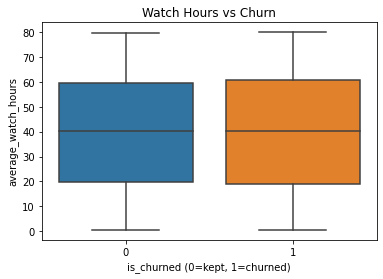

In [107]:


# --- Visuals: Boxplot, bar plots, histograms ---
plt.figure(figsize=(6,4))
sns.boxplot(x="is_churned", y="average_watch_hours", data=data)
plt.title("Watch Hours vs Churn")
plt.xlabel("is_churned (0=kept, 1=churned)")
plt.ylabel("average_watch_hours")
plt.show()

In [108]:
# Heavy mobile helper (if not already present)
if "heavy_mobile_user" not in data.columns:
    data["heavy_mobile_user"] = (data["mobile_app_usage_pct"] > 70).astype(int)

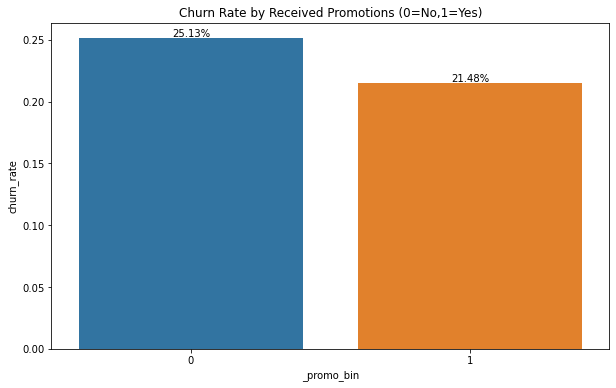

In [157]:

# Churn rate by promotions
if prom_bin is not None:
    tmp = data.copy()
    tmp["_promo_bin"] = prom_bin
#change the figure size
    plt.figure(figsize=(10, 6))
    promo_rates = tmp.groupby("_promo_bin")["is_churned"].mean().reset_index(name="churn_rate")
    sns.barplot(data=promo_rates, x="_promo_bin", y="churn_rate")
    plt.title("Churn Rate by Received Promotions (0=No,1=Yes)")
    for index, row in promo_rates.iterrows():
        plt.text(
            x=row['_promo_bin'],
            y=row['churn_rate'],
            s=f"{row['churn_rate']:.2%}",
            ha='center',
            va='bottom'
        )
    

    plt.show()

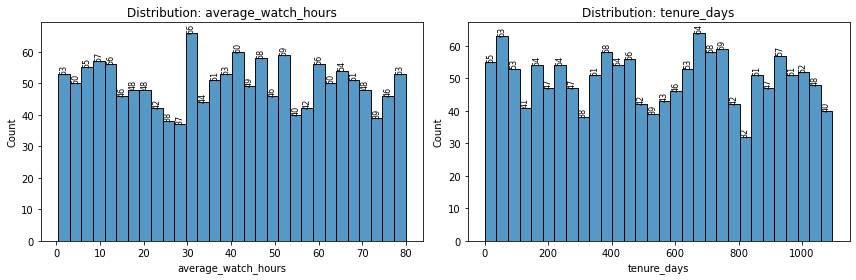

In [110]:
# Distributions with counts on bars
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Average watch hours ---
ax = axes[0]
sns.histplot(data["average_watch_hours"], bins=30, ax=ax)
ax.set_title("Distribution: average_watch_hours")

# Add count labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # only annotate non-empty bins
        ax.annotate(f"{int(height)}",
                    (p.get_x() + p.get_width()/2., height),
                    ha="center", va="bottom", fontsize=8, rotation=90)

# --- Tenure days ---
ax = axes[1]
sns.histplot(data["tenure_days"], bins=30, ax=ax)
ax.set_title("Distribution: tenure_days")

# Add count labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    (p.get_x() + p.get_width()/2., height),
                    ha="center", va="bottom", fontsize=8, rotation=90)

plt.tight_layout()
plt.show()


# Predictive Modelling 

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score,
    mean_squared_error, r2_score, mean_absolute_error
)

In [112]:
# ---------- Logistic Regression: predict is_churned ----------
# Use numeric features only; drop target
num_df = data.select_dtypes(include=[np.number]).copy()

# Ensure no NaNs remain
num_df = num_df.fillna(num_df.median(numeric_only=True))

y = num_df["is_churned"].astype(int)
X = num_df.drop(columns=["is_churned"])

In [113]:
# Train/test split (stratify keeps churn ratio similar)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [114]:
# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


In [115]:
# Fit model
log_reg = LogisticRegression(max_iter=1000, n_jobs=None)
log_reg.fit(X_train_s, y_train)

LogisticRegression(max_iter=1000)

In [116]:
# Predictions
y_pred = log_reg.predict(X_test_s)
y_prob = log_reg.predict_proba(X_test_s)[:, 1]

In [117]:
# Metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))
print("Precision:", precision_score(y_test, y_pred).round(3))
print("Recall:", recall_score(y_test, y_pred).round(3))
print("F1:", f1_score(y_test, y_pred).round(3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob).round(3))

Confusion Matrix:
 [[287   0]
 [ 87   0]]

Classification Report:
               precision    recall  f1-score   support

           0      0.767     1.000     0.868       287
           1      0.000     0.000     0.000        87

    accuracy                          0.767       374
   macro avg      0.384     0.500     0.434       374
weighted avg      0.589     0.767     0.666       374

Precision: 0.0
Recall: 0.0
F1: 0.0
ROC-AUC: 0.486


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metr

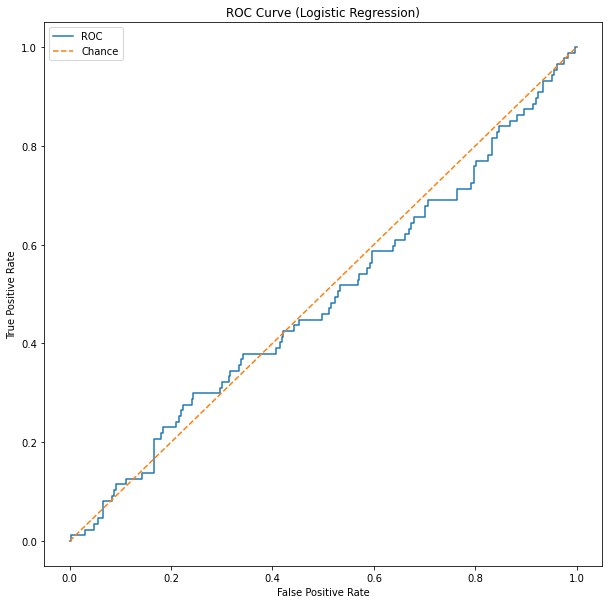

In [118]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],"--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.show()

In [119]:
# Coefficients (importance)
coef_series = pd.Series(log_reg.coef_[0], index=X.columns)
coef_sorted = coef_series.reindex(coef_series.abs().sort_values(ascending=False).index)
print("\nTop 10 predictors of churn (by |coef|):\n", coef_sorted.head(10))



Top 10 predictors of churn (by |coef|):
 gender_Other          -0.198168
country_India          0.115737
monthly_fee           -0.113552
gender_Male           -0.113368
is_loyal               0.111188
age                    0.098534
country_France         0.094255
country_UK             0.083815
watch_per_fee_ratio   -0.083001
age_group_18-25        0.064018
dtype: float64


In [120]:
# ---------- Linear Regression: predict average_watch_hours ----------
# Choose numeric predictors; drop target + leakage if required
features_lin = data.select_dtypes(include=[np.number]).columns.tolist()
for col in ["average_watch_hours", "is_churned"]:
    if col in features_lin:
        features_lin.remove(col)

X_lin = data[features_lin].fillna(data[features_lin].median(numeric_only=True))
y_lin = data["average_watch_hours"]

Xl_train, Xl_test, yl_train, yl_test = train_test_split(
    X_lin, y_lin, test_size=0.25, random_state=42
)


In [121]:
lin = LinearRegression()
lin.fit(Xl_train, yl_train)
yl_pred = lin.predict(Xl_test)

rmse = np.sqrt(mean_squared_error(yl_test, yl_pred))
mae  = mean_absolute_error(yl_test, yl_pred)
r2   = r2_score(yl_test, yl_pred)
print(f"\nLinear Regression (predict average_watch_hours)")
print(f"R²:  {r2:.3f}")
print(f"RMSE:{rmse:.3f}")
print(f"MAE: {mae:.3f}")


Linear Regression (predict average_watch_hours)
R²:  0.890
RMSE:7.231
MAE: 5.810


In [122]:

# Suppose  regression target is average_watch_hours
y_true = yl_test
y_pred_cont = yl_pred

# Step 1: Define a threshold to convert continuous watch hours into categories
threshold = np.median(y_true)   # e.g. split into low vs high watch time
y_true_class = (y_true >= threshold).astype(int)
y_pred_class = (y_pred_cont >= threshold).astype(int)

# Step 2: Confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)
print("Confusion Matrix:\n", cm)

# Step 3: Classification report
print("\nClassification Report:\n", classification_report(y_true_class, y_pred_class))


Confusion Matrix:
 [[186   0]
 [  9 179]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       186
           1       1.00      0.95      0.98       188

    accuracy                           0.98       374
   macro avg       0.98      0.98      0.98       374
weighted avg       0.98      0.98      0.98       374



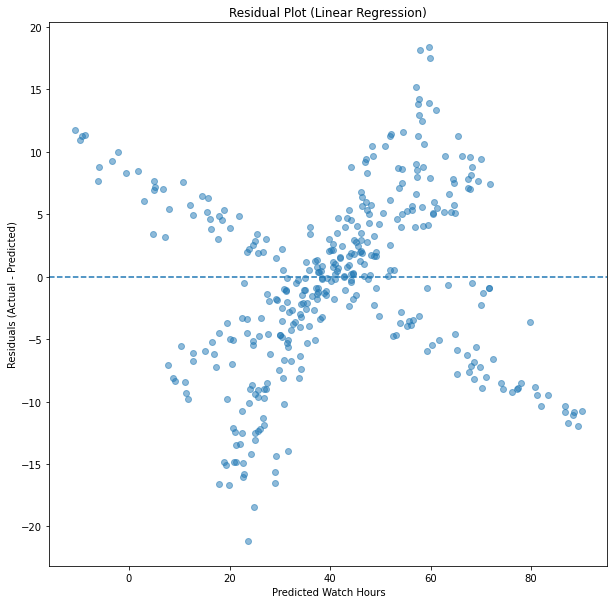


Top 10 predictors of watch hours (by |coef|):
 subscription_type_Premium    -8.722260
watch_per_fee_ratio           7.730187
monthly_fee                   4.618159
country_UK                    1.862358
country_USA                   1.792206
country_Germany               1.625176
heavy_mobile_user             1.607658
gender_Male                  -1.212999
subscription_type_Standard    1.160036
country_India                 0.956269
dtype: float64


In [123]:
# Residual plot
resid = yl_test - yl_pred
plt.figure(figsize=(10,10))
plt.scatter(yl_pred, resid, alpha=0.5)
plt.axhline(0, ls="--")
plt.xlabel("Predicted Watch Hours")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Linear Regression)")
plt.show()

lin_coef = pd.Series(lin.coef_, index=X_lin.columns)
lin_coef_sorted = lin_coef.reindex(lin_coef.abs().sort_values(ascending=False).index)
print("\nTop 10 predictors of watch hours (by |coef|):\n", lin_coef_sorted.head(10))

# Business Questions (Tables + Plots)

In [124]:
# Helper to (re)build binary columns if needed
def get_binary_series(df, base_name):
    if base_name in df.columns:
        s = df[base_name]
        if s.dtype == "O":
            return s.astype(str).str.strip().str.lower().map({"yes":1,"no":0,"1":1,"0":0,"true":1,"false":0}).fillna(0).astype(int)
        if np.issubdtype(s.dtype, np.number):
            return s.fillna(0).astype(int)
    for c in [f"{base_name}_Yes", f"{base_name}_yes"]:
        if c in df.columns:
            return df[c].fillna(0).astype(int)
    return None

promo_bin = get_binary_series(data, "received_promotions")
ref_bin   = get_binary_series(data, "referred_by_friend")

In [128]:
# Ensure heavy_mobile_user exists
if "heavy_mobile_user" not in data.columns:
    data["heavy_mobile_user"] = (data["mobile_app_usage_pct"] > 70).astype(int)


1) Churn rate by Received Promotions (0=No,1=Yes):
    _promo_bin  churn_rate    n
0           0    0.251309  764
1           1    0.214774  731 



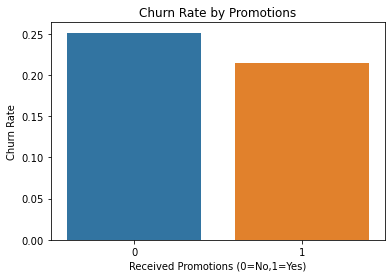

In [144]:
# 1) Do users who receive promotions churn less?
if promo_bin is not None:
    df1 = data.copy()

    promo_summary = df1.groupby("_promo_bin")["is_churned"].agg(churn_rate="mean", n="count").reset_index()
    print("1) Churn rate by Received Promotions (0=No,1=Yes):\n", promo_summary, "\n")
    sns.barplot(data=promo_summary, x="_promo_bin", y="churn_rate")
    plt.title("Churn Rate by Promotions")
    plt.xlabel("Received Promotions (0=No,1=Yes)"); plt.ylabel("Churn Rate")
    plt.show()
else:
    print("1) Promotions column not found in expected formats.\n")

2) Watch time by churn status:
    is_churned       mean  median  count
0           0  39.980628    40.3   1146
1           1  39.714327    40.3    349 



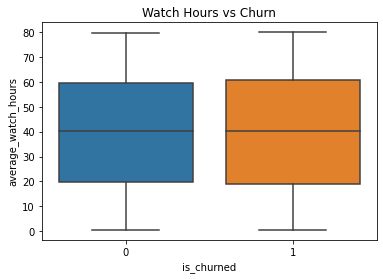

In [131]:
# 2) Does watch time impact churn likelihood?
watch_summary = data.groupby("is_churned")["average_watch_hours"].agg(["mean","median","count"]).reset_index()
print("2) Watch time by churn status:\n", watch_summary, "\n")
plt.figure(figsize=(6,4))
sns.boxplot(x="is_churned", y="average_watch_hours", data=data)
plt.title("Watch Hours vs Churn"); plt.show()

3) Churn rate: Heavy Mobile (1=True):
    heavy_mobile_user  churn_rate     n
0                  0    0.229637  1019
1                  1    0.241597   476 



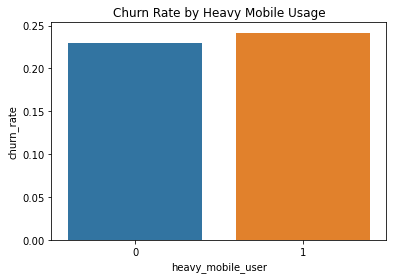

In [132]:
# 3) Are mobile-dominant users more likely to cancel?
hm_summary = data.groupby("heavy_mobile_user")["is_churned"].agg(churn_rate="mean", n="count").reset_index()
print("3) Churn rate: Heavy Mobile (1=True):\n", hm_summary, "\n")
sns.barplot(data=hm_summary, x="heavy_mobile_user", y="churn_rate")
plt.title("Churn Rate by Heavy Mobile Usage"); plt.show()

In [133]:
 #4) Top 3 features influencing churn (from logistic model)
#     
try:
    print("4) Top 3 churn predictors (|coef|):\n", coef_sorted.head(3), "\n")
except NameError:
    print("4) Please run Step 5 (logistic regression) first to compute coefficients.\n")

4) Top 3 churn predictors (|coef|):
 gender_Other    -0.198168
country_India    0.115737
monthly_fee     -0.113552
dtype: float64 



In [134]:
# 5) Which customer segments should the retention team prioritise?
# Define a simple segmentation: low watch, heavy mobile, and promotions
data["low_watch"] = (data["average_watch_hours"] <= data["average_watch_hours"].median()).astype(int)
seg_cols = ["low_watch", "heavy_mobile_user"]
if promo_bin is not None:
    data["_promo_bin"] = promo_bin
    seg_cols.append("_promo_bin")

seg_summary = (data.groupby(seg_cols)["is_churned"]
               .agg(churn_rate="mean", n="count")
               .reset_index()
               .sort_values(["churn_rate","n"], ascending=[False, False]))
print("5) Segments ranked by churn rate (top 10):\n", seg_summary.head(10), "\n")

5) Segments ranked by churn rate (top 10):
    low_watch  heavy_mobile_user  _promo_bin  churn_rate    n
2          0                  1           0    0.300000  120
4          1                  0           0    0.290076  262
3          0                  1           1    0.247934  121
1          0                  0           1    0.221344  253
6          1                  1           0    0.219697  132
0          0                  0           0    0.204000  250
5          1                  0           1    0.200787  254
7          1                  1           1    0.194175  103 



In [135]:
# 6) What factors affect user watch time or tenure? (Linear regression insight)
#     
try:
    print("6) Top 3 predictors of watch hours (|coef|):\n", lin_coef_sorted.head(3), "\n")
except NameError:
    print("6) Please run Step 5 (linear regression) first to compute coefficients.\n")

6) Top 3 predictors of watch hours (|coef|):
 subscription_type_Premium   -8.722260
watch_per_fee_ratio          7.730187
monthly_fee                  4.618159
dtype: float64 



In [136]:
# --- Stretch Goals: Alternative Models, Class Imbalance Handling, GridSearchCV ---


# Define features and target again
X = data.drop(columns=["is_churned"])
y = data["is_churned"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include="number"))
X_test_scaled = scaler.transform(X_test.select_dtypes(include="number"))
# Logistic Regression with class_weight
log_reg_balanced = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg_balanced.fit(X_train_scaled, y_train)
y_pred_lr = log_reg_balanced.predict(X_test_scaled)

print("\nBalanced Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))



Balanced Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.78      0.52      0.62       229
           1       0.24      0.51      0.33        70

    accuracy                           0.52       299
   macro avg       0.51      0.51      0.48       299
weighted avg       0.65      0.52      0.55       299



In [147]:
 #Random Forest with class_weight
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("\nRandom Forest Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       229
           1       0.00      0.00      0.00        70

    accuracy                           0.77       299
   macro avg       0.38      0.50      0.43       299
weighted avg       0.59      0.77      0.66       299



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [149]:

# SVM with class_weight
from sklearn.svm import SVC
svm = SVC(class_weight="balanced", probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

print("\nSVM Report:")
print(classification_report(y_test, y_pred_svm))



SVM Report:
              precision    recall  f1-score   support

           0       0.78      0.62      0.69       229
           1       0.26      0.44      0.33        70

    accuracy                           0.58       299
   macro avg       0.52      0.53      0.51       299
weighted avg       0.66      0.58      0.60       299



In [151]:

# --- Hyperparameter Tuning for Logistic Regression ---
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    param_grid,
    cv=5,
    scoring="f1"
)

grid_lr.fit(X_train_scaled, y_train)
print("\nBest Logistic Regression Params from GridSearchCV:", grid_lr.best_params_)



Best Logistic Regression Params from GridSearchCV: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [152]:
print(data.columns.tolist())

['age', 'signup_date', 'last_active_date', 'average_watch_hours', 'mobile_app_usage_pct', 'complaints_raised', 'received_promotions', 'referred_by_friend', 'is_churned', 'monthly_fee', 'tenure_days', 'is_loyal', 'watch_per_fee_ratio', 'heavy_mobile_user', 'promo_low_watch', 'gender_Male', 'gender_Other', 'country_France', 'country_Germany', 'country_India', 'country_UK', 'country_USA', 'subscription_type_Premium', 'subscription_type_Standard', 'age_group_18-25', 'age_group_26-35', 'age_group_36-50', 'age_group_50+', 'low_watch', '_promo_bin']


In [153]:
# --- Segment churn by country (one-hot columns) ---
country_cols = [c for c in data.columns if c.startswith("country_")]
if country_cols:
    churn_by_country = {}
    for col in country_cols:
        churn_rate = data.loc[data[col] == 1, "is_churned"].mean()
        churn_by_country[col] = churn_rate
    churn_by_country = pd.Series(churn_by_country).sort_values(ascending=False)
    print("\nChurn Rate by Country:\n", churn_by_country)
else:
    print("No country columns found.")

# --- Segment churn by subscription type (one-hot columns) ---
sub_cols = [c for c in data.columns if c.startswith("subscription_type_")]
if sub_cols:
    churn_by_sub = {}
    for col in sub_cols:
        churn_rate = data.loc[data[col] == 1, "is_churned"].mean()
        churn_by_sub[col] = churn_rate
    churn_by_sub = pd.Series(churn_by_sub).sort_values(ascending=False)
    print("\nChurn Rate by Subscription Type:\n", churn_by_sub)
else:
    print(" No subscription type columns found.")

# --- Segment churn by gender (one-hot columns) ---
gender_cols = [c for c in data.columns if c.startswith("gender_")]
if gender_cols:
    churn_by_gender = {}
    for col in gender_cols:
        churn_rate = data.loc[data[col] == 1, "is_churned"].mean()
        churn_by_gender[col] = churn_rate
    # Add baseline Female (where all gender_ dummies == 0)
    female_churn = data.loc[(data[gender_cols].sum(axis=1) == 0), "is_churned"].mean()
    churn_by_gender["gender_Female"] = female_churn
    churn_by_gender = pd.Series(churn_by_gender).sort_values(ascending=False)
    print("\nChurn Rate by Gender:\n", churn_by_gender)
else:
    print("No gender columns found.")


Churn Rate by Country:
 country_UK         0.273859
country_India      0.241245
country_France     0.237154
country_Germany    0.225410
country_USA        0.212766
dtype: float64

Churn Rate by Subscription Type:
 subscription_type_Standard    0.246436
subscription_type_Premium     0.216433
dtype: float64

Churn Rate by Gender:
 gender_Female    0.264706
gender_Male      0.217842
gender_Other     0.216700
dtype: float64


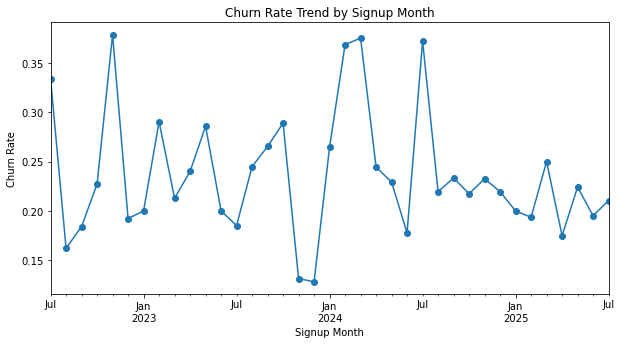

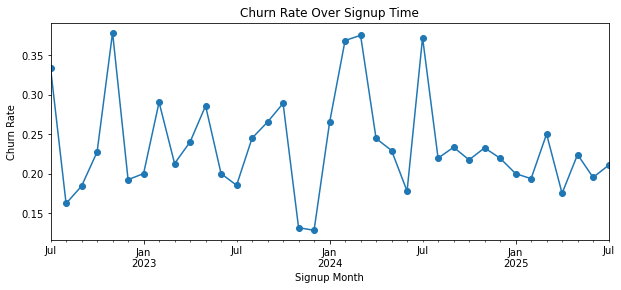

In [154]:
# --- Time Series: churn trend over signup_date ---
data["signup_date"] = pd.to_datetime(data["signup_date"], errors="coerce")
churn_trend = data.groupby(data["signup_date"].dt.to_period("M"))["is_churned"].mean()

plt.figure(figsize=(10,5))
churn_trend.plot(marker="o")
plt.title("Churn Rate Trend by Signup Month")
plt.ylabel("Churn Rate")
plt.xlabel("Signup Month")
plt.show()# 7. Time Series Analysis
# -------------------------------
data["signup_date"] = pd.to_datetime(data["signup_date"], errors="coerce")
data["last_active_date"] = pd.to_datetime(data["last_active_date"], errors="coerce")

churn_over_time = data.groupby(data["signup_date"].dt.to_period("M"))["is_churned"].mean()

plt.figure(figsize=(10,4))
churn_over_time.plot(kind="line", marker="o")
plt.title("Churn Rate Over Signup Time")
plt.ylabel("Churn Rate")
plt.xlabel("Signup Month")
plt.show()